In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance


# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

# data (as pandas dataframes)
X = real_estate_valuation.data.features
y = real_estate_valuation.data.targets

X = X[['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']]

# Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)


In [ ]:
# Linear Regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)


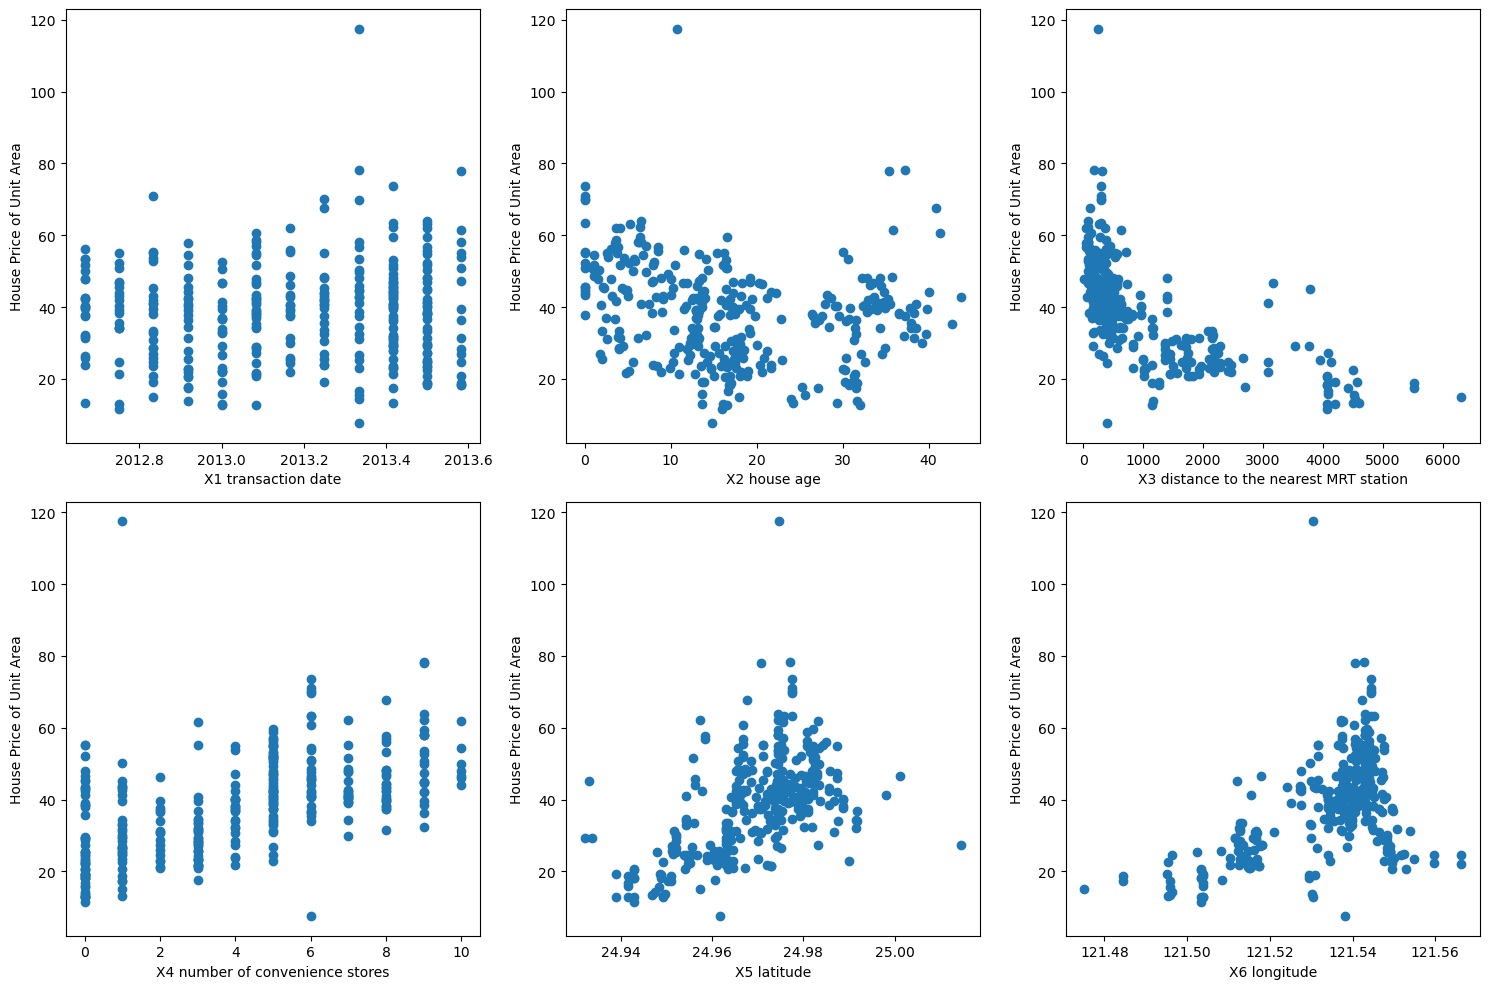

In [75]:
# List of features to plot
features = ['X1 transaction date', 'X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores', 'X5 latitude', 'X6 longitude']

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features):
    axes[i].scatter(X_train[feature], y_train)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('House Price of Unit Area')

plt.tight_layout()
plt.show()

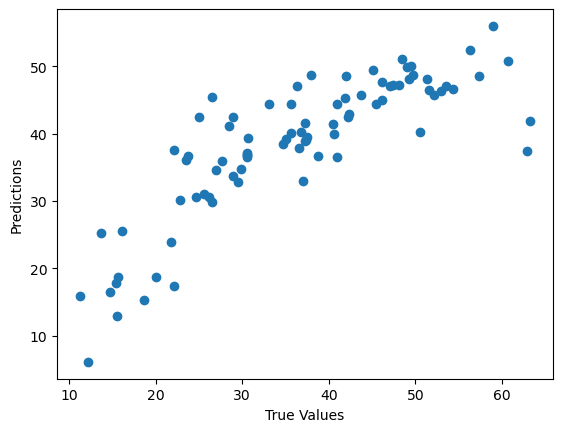

In [78]:
# Plotting the results
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [77]:
# Evaluation of Linear Regression
print("Linear Regression Metrics:")
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('R2 Score:', r2_score(y_test, y_pred))

b0 = model.intercept_
b1, b2, b3, b4, b5, b6 = model.coef_[0]
print("Intercept:", b0)
print("Coefficients:")
print("X1 transaction date:", b1)
print("X2 house age:", b2)
print("X3 distance to the nearest MRT station:", b3)
print("X4 number of convenience stores:", b4)
print("X5 latitude:", b5)
print("X6 longitude:", b6)

Linear Regression Metrics:
Mean Absolute Error: 5.736478809674765
Mean Squared Error: 57.85793466977276
R2 Score: 0.6551143134174902
Intercept: [38.39154079]
Coefficients:
X1 transaction date: 1.5296311293386962
X2 house age: -3.0626944118090966
X3 distance to the nearest MRT station: -5.786925608033045
X4 number of convenience stores: 3.2188727017566388
X5 latitude: 2.855107847927548
X6 longitude: -0.44100860256121255


AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

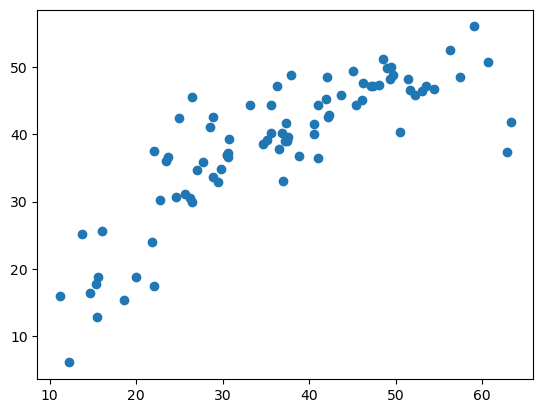

In [85]:
# Scatter plot
plt.scatter(y_test, y_pred, label='Predictions')

# Flatten the arrays
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Fit a polynomial of degree 1 (linear regression)
coefficients = np.polyfit(y_test_flat, y_pred_flat, 1)
polynomial = np.poly1d(coefficients)

# Generate y-values for the trendline
trendline = polynomial(y_test)

# Plot the trendline
plt.plot(y_test, trendline, color='red', label='Trendline')

plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.show()